# Traitement des données :

Dans un premier temps, à partir de ma base brute **"DVF_80.csv"** je devais retirer un grand nombre de colonnes qui ne me servait pas dans mon étude de la valeur. Le choix a été minutieux, de façon à ne pas retirer de potentiel features importantes. 

Pour ce faire, j'ai utilisé MySQL et SQLite. MySQL me permettait de faire de plus grosses requêtes comparées à SQLite qui ne peut DROP qu'une colonne à la fois par exemple : 

[SQL Drop command](SQL/SQL_Drop.png)

Dans un second temps, j'ai retiré toutes les natures de mutation qui sont autres que des ventes.

[SQL Delete != ventes](SQL/SQL_Delete_first_step.png)

Par la suite, j'ai supprimé un ensemble de lignes comprenant des NULL, ou bien des types de bien qui ne correspondait pas.

[SQL Delete ...](SQL/SQL_Delete_other.png)

Une fois mes données retraitées, je peux procéder à l'analyse.



## Analyse avec Python

In [131]:
# Import
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
# Possibilité d'afficher les données de base pour comparer

# df = pd.read_csv("Data/DVF_80.csv")
# df.head()

# print(df.shape)

# print(df.describe(include="all"))


In [133]:
df_step2 = pd.read_csv("Data/DVF_80_retraitees.csv")
df_step2.head()

,id_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati
0,2023-432445,Vente,163500.0,80580,Maison,85
1,2023-432446,Vente,190500.0,80480,Maison,59
2,2023-432447,Vente,365000.0,80000,Local industriel. commercial ou assimilé,392
3,2023-432447,Vente,365000.0,80000,Appartement,51
4,2023-432448,Vente,220000.0,80150,Maison,84


In [134]:
# Affichage du nombre de ligne et de colonne
print(df_step2.shape)

# Affichage des colonnes qui contiennent des valeurs null --> normalement il ne devrait pas en avoir après mon retraitement de données en SQL
df_step2.isnull().any()


(4397, 6)


id_mutation            False
nature_mutation        False
valeur_fonciere        False
code_postal            False
type_local             False
surface_reelle_bati    False
dtype: bool

In [135]:
# Affichage des informations statistiques essentielles
## Numeric
df_step2_numeric = df_step2[["valeur_fonciere", "surface_reelle_bati"]]
df_step2_numeric.describe(include="all")



,valeur_fonciere,surface_reelle_bati
count,4.397000e+03,4397.000000
mean,2.074016e+05,128.068001
std,3.380510e+05,776.355967
min,1.000000e+00,3.000000
25%,9.700000e+04,52.000000
50%,1.500000e+05,77.000000
75%,2.247500e+05,105.000000
max,7.380000e+06,31635.000000


In [136]:
# Affichage des informations statistiques essentielles
## Catégoriel
df_step2_categorical = df_step2[["nature_mutation", "code_postal", "type_local"]]
df_step2_categorical.describe(include="all")


,nature_mutation,code_postal,type_local
count,4397,4397.000000,4397
unique,1,NaN,3
top,Vente,NaN,Maison
freq,4397,NaN,3079
mean,NaN,80283.294292,NaN
std,NaN,243.745282,NaN
min,NaN,80000.000000,NaN
25%,NaN,80090.000000,NaN
50%,NaN,80210.000000,NaN
75%,NaN,80460.000000,NaN


Je décide par la suite de supprimer les valeurs extrêmes car elles viennent fausser mes tendances et ne sont pas représentative du reste de ma base. Pour ce faire j'applique la méthode de l'écart inter-quartiles.

In [137]:
# Retirer les valeurs extrêmes pour la valeur_fonciere
Q1 = df_step2["valeur_fonciere"].quantile(0.25)
Q3 = df_step2["valeur_fonciere"].quantile(0.75)

IQR = Q3 - Q1

# Bornes acceptables
borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

df_sans_extremes = df_step2[(df_step2["valeur_fonciere"] >= borne_inf) & (df_step2["valeur_fonciere"] <= borne_sup)]

df_sans_extremes

,id_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati
0,2023-432445,Vente,163500.0,80580,Maison,85
1,2023-432446,Vente,190500.0,80480,Maison,59
2,2023-432447,Vente,365000.0,80000,Local industriel. commercial ou assimilé,392
3,2023-432447,Vente,365000.0,80000,Appartement,51
4,2023-432448,Vente,220000.0,80150,Maison,84
...,...,...,...,...,...,...
4391,2023-437413,Vente,137100.0,80860,Maison,60
4392,2023-437414,Vente,1000.0,80640,Maison,45
4394,2023-437416,Vente,160000.0,80200,Maison,75
4395,2023-437419,Vente,227000.0,80130,Maison,123


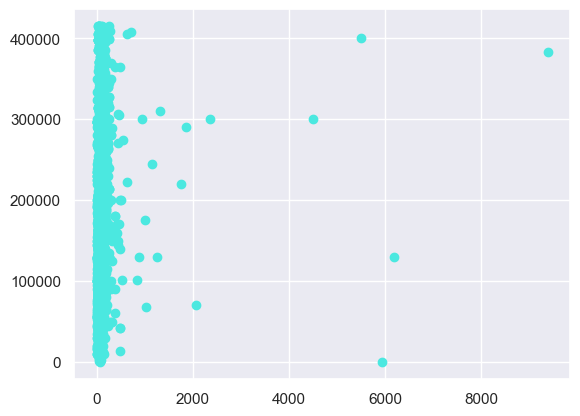

In [138]:
# Affichage du nuage de point pour visualiser la tendance
plt.scatter(df_sans_extremes.iloc[:, 5], df_sans_extremes.iloc[:, 2], color="#4BE8E0")
plt.show()

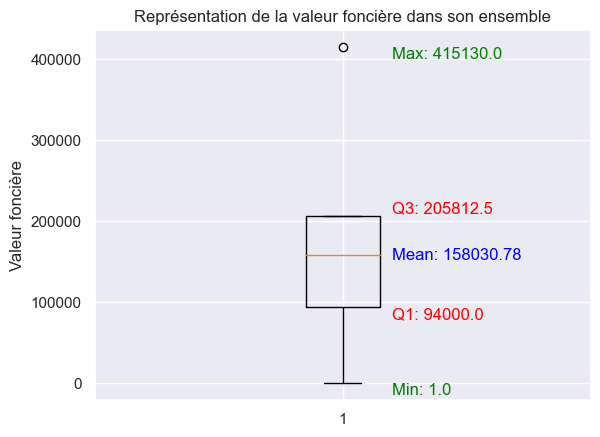

In [139]:
# Affichage d'un graphique boxplot mettant en avant les éléments principaux comme les quartiles, les min / max et la moyenne

max_value = df_sans_extremes['valeur_fonciere'].max()
min_value = df_sans_extremes['valeur_fonciere'].min()
mean_value = round(df_sans_extremes['valeur_fonciere'].mean(),2)
q1 = df_sans_extremes['valeur_fonciere'].quantile(0.25)
q3 = df_sans_extremes['valeur_fonciere'].quantile(0.75)

plt.boxplot([min_value, q1, mean_value, q3, max_value])

plt.text(1.1, max_value, f"Max: {max_value}", ha='left', va='top', color='green')
plt.text(1.1, q1, f"Q1: {q1}", ha='left', va='top', color='red')
plt.text(1.1, mean_value, f"Mean: {mean_value}", ha='left', va='center', color='blue')
plt.text(1.1, q3, f"Q3: {q3}", ha='left', va='bottom', color='red')
plt.text(1.1, min_value, f"Min: {min_value}", ha='left', va='top', color='green')


plt.ylabel("Valeur foncière")
plt.title("Représentation de la valeur foncière dans son ensemble")

plt.show()

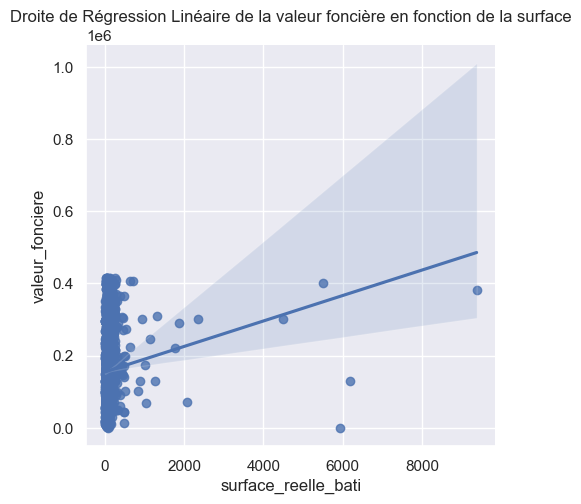

In [140]:
# Traçage d'une droite de régression linéaire lié à mon nuage de point

sns.set(style="darkgrid")
sns.lmplot(x="surface_reelle_bati", y="valeur_fonciere", data=df_sans_extremes)

plt.title("Droite de Régression Linéaire de la valeur foncière en fonction de la surface")

plt.show()

Malgré des valeurs extrêmes et un regroupement de données, je décide de partir sur un modèle de régression linéaire. J'imagine qu'une tendance va ressortir de la superficie des biens et du type de bien, permettant d'envisager sa valeur.

## Machine Learning --> Modèle de régression linéaire

In [141]:
# Rappel des colonnes

df_sans_extremes.head()

,id_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati
0,2023-432445,Vente,163500.0,80580,Maison,85
1,2023-432446,Vente,190500.0,80480,Maison,59
2,2023-432447,Vente,365000.0,80000,Local industriel. commercial ou assimilé,392
3,2023-432447,Vente,365000.0,80000,Appartement,51
4,2023-432448,Vente,220000.0,80150,Maison,84


In [142]:
# Séparation de la variable cible Y et de la variable "features" X

print("Separating labels from features...")
feature_list=["surface_reelle_bati", "type_local"]
X = df_sans_extremes.loc[:,feature_list]
y = df_sans_extremes.loc[:,"valeur_fonciere"]
print("...Done.")
print()

Separating labels from features...
...Done.



In [143]:
# Division du dataset en Train / Test

print("Splitting dataset into train set and test set...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

print("...Done.")  

# Visualisation de mon X_train

print(X_train.head())

Splitting dataset into train set and test set...
...Done.
      surface_reelle_bati                                type_local
952                    45  Local industriel. commercial ou assimilé
1549                  106                                    Maison
4187                   45                                    Maison
3481                   46                               Appartement
1883                   57                               Appartement


In [144]:
### Training pipeline ###
print("--- Training pipeline ---")
print()  

# Encodage des "categorical features" et standardisation des "numeric features"

print("#### X_train BEFORE preprocessing ####")
print(X_train.head())
print()

print("Encoding categorical features and standardizing numerical features...")

print()

numeric_features = [0]
numeric_transformer = StandardScaler()

categorical_features = [1]
categorical_transformer = OneHotEncoder(drop='first')

feature_encoder = ColumnTransformer(
    transformers=[  
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ]
    )

X_train = feature_encoder.fit_transform(X_train)
print("...Done.")
print(X_train[:5]) 
print()

--- Training pipeline ---

#### X_train BEFORE preprocessing ####
      surface_reelle_bati                                type_local
952                    45  Local industriel. commercial ou assimilé
1549                  106                                    Maison
4187                   45                                    Maison
3481                   46                               Appartement
1883                   57                               Appartement

Encoding categorical features and standardizing numerical features...

...Done.
[[-0.21639299  1.          0.        ]
 [ 0.05113077  0.          1.        ]
 [-0.21639299  0.          1.        ]
 [-0.21200736  0.          0.        ]
 [-0.16376537  0.          0.        ]]



In [145]:
# Train model

print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, y_train) 
print("...Done.")

Train model...
...Done.


In [146]:
# Prédiction sur le training set
print("Predictions on training set...")
y_train_pred = regressor.predict(X_train)
print("...Done.")
print(y_train_pred[:5]) 
print()

Predictions on training set...
...Done.
[159255.20743459 157742.59850305 155515.71039242 161208.87840325
 161610.44839041]



In [147]:
### Testing pipeline ###
print("--- Testing pipeline ---")

# Standardisation des "numeric features"
print("Standardizing numerical features...")
print(X_test)
print()

X_test = feature_encoder.transform(X_test)

print("...Done.")
print(X_test[:5])
print()

--- Testing pipeline ---
Standardizing numerical features...
      surface_reelle_bati                                type_local
1172                  100                                    Maison
51                     56                                    Maison
1696                   51                                    Maison
1394                   37                               Appartement
3459                   82                                    Maison
...                   ...                                       ...
223                   115                                    Maison
56                     50  Local industriel. commercial ou assimilé
104                    56                                    Maison
1641                  102                                    Maison
3653                  102                                    Maison

[826 rows x 2 columns]

...Done.
[[ 0.02481696  0.          1.        ]
 [-0.168151    0.          1.        ]
 [-0.190079

In [148]:
# Prédiction du test set

print("Predictions on test set...")
y_test_pred = regressor.predict(X_test)
print("...Done.")
print(y_test_pred[:5])
print()

Predictions on test set...
...Done.
[157523.56032823 155917.28037958 155734.74856723 160880.32114102
 156866.44580378]



In [149]:
# Calcul des performances
print("--- Assessing the performances of the model ---")

# Performances R^2 scores
print("R2 score on training set : ", regressor.score(X_train, y_train))
print("R2 score on test set : ", regressor.score(X_test, y_test))

--- Assessing the performances of the model ---
R2 score on training set :  0.01048236786361001
R2 score on test set :  0.006665110423755394


[Conclusion](readme.ipynb)